## Satellite Accretion in the Local Group

This notebook analyzes the **accretion histories and properties** of satellites
around the Milky Way (MW) and M31 analogs in three HESTIA simulations.

Main goals:


Reference:
Dupuy et al. (2022), *"Anisotropic satellite accretion onto the Local Group with HESTIA"*
[arXiv:2208.14648](https://arxiv.org/abs/2208.14648)

In [2]:
import numpy as np
import numpy.lib.recfunctions as rfn
from astropy.coordinates import SkyCoord, CartesianRepresentation
from astropy import units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
mpl.rcParams['figure.dpi']= 100

In [3]:
# List of simulation IDs you want to analyze.
# Each string corresponds to a different HESTIA Local Group simulation.
SIMS = ['09_18', '17_11', '37_11']

### Loading HESTIA Satellite Infall Data

We load the **satellite infall datasets** from the three HESTIA Local Group simulations  
(`09_18`, `17_11`, `37_11`).

The function `load_infall_data(rvir)` does the following:

1. Loads the `out_infall` text files for each simulation at the chosen virial radius (`rvir`).  
2. Combines all three simulations into a single structured array (`out`) and keeps track of the simulation IDs (`out_id`).  
3. Splits satellites into **M31** (`sat == 1`) and **MW** (`sat == 2`) subsets.  
4. Returns the arrays:
   - `out`, `out_id` - all satellites and their simulation IDs
   - `m31`, `m31_id` - M31 satellites and IDs
   - `mw`, `mw_id` - MW satellites and IDs
   
5. Prints a summary of satellite counts by baryonic content at infall:
   - DM-only (no gas or stars)  
   - Baryons (gas and/or stars)  
   - Gas-only  
   - Stars-only

You can call this function for different `rvir` values, e.g., `2.0rvir` or `1.0rvir`) to study how the results change with the selection radius.

In [4]:
def load_infall_data(rvir='2.0rvir'):
    """
    Load and combine infall data for all simulations.

    Parameters
    ----------
    rvir : str, optional
        Virial radius label used for file selection (default: '2.0rvir').

    Returns
    -------
    out : np.ndarray
        Combined infall data from all simulations.
    out_id : np.ndarray
        Simulation identifiers ('09_18', '17_11', '37_11') for each entry in `out`.
    m31, m31_id : np.ndarray
        Subset and IDs for M31 satellites.
    mw, mw_id : np.ndarray
        Subset and IDs for MW satellites.
    """

    print(f"Loading infall data for rvir = {rvir}")

    # Define column data types and names for the infall files
    dtype = [
        int, int,
        float, float, float, float, float, float,        # zinf + positions/velocities at infall
        float, float, float,                             # masses at infall
        float, float, float, float, float, float,        # current positions/velocities
        float, float, float,                             # current masses
        float, float, float, float, float, float,        # Local Group coordinates and velocities
        float, float, float, float, float, float, float, # birth info
        float                                            # rvir
    ]

    names = [
        'id', 'sat', 'zinf',
        'xcinf', 'ycinf', 'zcinf', 'vxinf', 'vyinf', 'vzinf',
        'Mvir_inf', 'Mgas_inf', 'Mstar_inf',
        'xc0', 'yc0', 'zc0', 'vx0', 'vy0', 'vz0',
        'Mvir0', 'Mgas0', 'Mstar0',
        'xclg', 'yclg', 'zclg', 'vxlg', 'vylg', 'vzlg',
        'zbirth', 'xcbirth', 'ycbirth', 'zcbirth',
        'xlgbirth', 'ylgbirth', 'zlgbirth', 'rvir'
    ]

    # Load infall data from each simulation
    out_data = []
    for sim in SIMS:
        file_path = f"infall_output/out_infall_{sim}_{rvir}.txt"
        data = np.genfromtxt(file_path, dtype=dtype, names=names)
        print(f"{sim}: {data.shape[0]} entries")
        out_data.append(data)

    # Combine all simulations into one array
    out = rfn.stack_arrays(out_data, defaults=None, usemask=False, asrecarray=False)
    print(f"Total (3 simulations): {out.shape[0]} entries")

    # Create simulation ID labels
    ids = np.concatenate([
        np.repeat('09_18', out_data[0].shape[0]),
        np.repeat('17_11', out_data[1].shape[0]),
        np.repeat('37_11', out_data[2].shape[0])
    ])

    # Split by host galaxy (1 = M31, 2 = MW)
    m31_mask = out['sat'] == 1
    mw_mask  = out['sat'] == 2

    m31, m31_id = out[m31_mask], ids[m31_mask]
    mw, mw_id   = out[mw_mask], ids[mw_mask]

    # Print summary statistics for each host
    def summarize(label, data):
        n_total = data.shape[0]
        dm_only = ((data['Mstar_inf'] == 0) & (data['Mgas_inf'] == 0)).sum()
        baryons = ((data['Mstar_inf'] != 0) | (data['Mgas_inf'] != 0)).sum()
        gas_only = ((data['Mstar_inf'] == 0) & (data['Mgas_inf'] != 0)).sum()
        stars_only = ((data['Mstar_inf'] != 0) & (data['Mgas_inf'] == 0)).sum()

        print(f"\n# {label} satellites: {n_total}")
        print(f"  DM only  : {dm_only}")
        print(f"  Baryons  : {baryons}")
        print(f"  Gas only : {gas_only}")
        print(f"  Stars only: {stars_only}")

    summarize("M31", m31)
    summarize("MW", mw)

    return out, ids, m31, m31_id, mw, mw_id

Here we load the infall data for **two different selection radii** to study how satellite properties depend on the choice of R200.

In [5]:
# Load infall data at 2R_200 from all three simulations
out_2r200, out_2r200_id, m31_2r200, m31_2r200_id, mw_2r200, mw_2r200_id = load_infall_data(rvir='2.0rvir')

Loading infall data for rvir = 2.0rvir
09_18: 1775 entries
17_11: 1891 entries
37_11: 820 entries
Total (3 simulations): 4486 entries

# M31 satellites: 2364
  DM only  : 2137
  Baryons  : 227
  Gas only : 34
  Stars only: 31

# MW satellites: 2122
  DM only  : 1928
  Baryons  : 194
  Gas only : 25
  Stars only: 41


In [7]:
# Load infall data at R_200 from all three simulations
out_r200, out_r200_id, m31_r200, m31_r200_id, mw_r200, mw_r200_id = load_infall_data(rvir='1.0rvir')

Loading infall data for rvir = 1.0rvir
09_18: 1953 entries
17_11: 2150 entries
37_11: 924 entries
Total (3 simulations): 5027 entries

# M31 satellites: 2706
  DM only  : 2561
  Baryons  : 145
  Gas only : 1
  Stars only: 92

# MW satellites: 2321
  DM only  : 2189
  Baryons  : 132
  Gas only : 0
  Stars only: 74


### Accretion history

We examine **when satellites were accreted** onto the Milky Way (MW) and M31 analogs by plotting the distribution of their **infall redshifts** (`z_inf`).
- Thin lines: distributions from individual HESTIA simulations (`09_18`, `17_11`, `37_11`)
- **M31 satellites** - blue
- **MW satellites** - red
- Thick solid lines: combined distributions for each host across all simulations.

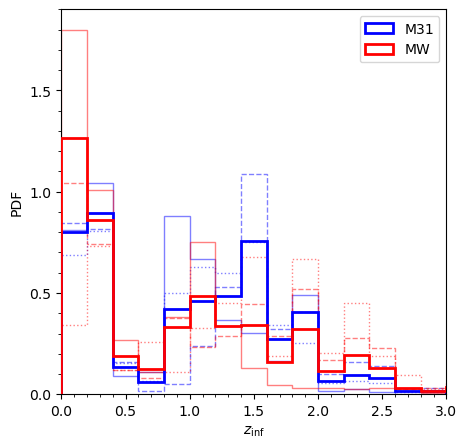

In [ ]:
"""
Plot infall redshift distributions (z_inf) for MW and M31 satellites,
showing individual simulations and combined distributions.
"""

# Create a square figure for the histogram comparison
f, ax = plt.subplots(1, 1, figsize=(5, 5))

# Individual simulations – M31
# Plot infall redshift distributions (z_inf) of M31 satellites
# for each of the three simulated Local Groups.
ax.hist(m31_2r200['zinf'][m31_2r200_id == '09_18'],
        bins=np.arange(0, 5.1, 0.2), density=True,
        color='blue', histtype='step', alpha=0.5,
        ls='solid', lw=1, zorder=0)
ax.hist(m31_2r200['zinf'][m31_2r200_id == '17_11'],
        bins=np.arange(0, 5.1, 0.2), density=True,
        color='blue', histtype='step', alpha=0.5,
        ls='dashed', lw=1, zorder=0)
ax.hist(m31_2r200['zinf'][m31_2r200_id == '37_11'],
        bins=np.arange(0, 5.1, 0.2), density=True,
        color='blue', histtype='step', alpha=0.5,
        ls='dotted', lw=1, zorder=0)

# Individual simulations – MW
# Same for the Milky Way satellites
ax.hist(mw_2r200['zinf'][mw_2r200_id == '09_18'],
        bins=np.arange(0, 5.1, 0.2), density=True,
        color='red', histtype='step', alpha=0.5,
        ls='solid', lw=1, zorder=1)
ax.hist(mw_2r200['zinf'][mw_2r200_id == '17_11'],
        bins=np.arange(0, 5.1, 0.2), density=True,
        color='red', histtype='step', alpha=0.5,
        ls='dashed', lw=1, zorder=1)
ax.hist(mw_2r200['zinf'][mw_2r200_id == '37_11'],
        bins=np.arange(0, 5.1, 0.2), density=True,
        color='red', histtype='step', alpha=0.5,
        ls='dotted', lw=1, zorder=1)

# Combined distributions
# Overlay the combined PDFs for all M31 and MW satellites
# across the three simulated Local Groups.
ax.hist(m31_2r200['zinf'],
        bins=np.arange(0, 5.1, 0.2), histtype='step',
        color='blue', label='M31', density=True,
        lw=2, zorder=2)
ax.hist(mw_2r200['zinf'],
        bins=np.arange(0, 5.1, 0.2), histtype='step',
        color='red', label='MW', density=True,
        lw=2, zorder=3)

# Axis formatting
ax.set_xlabel(r'$z_\mathrm{inf}$')   # Redshift at infall
ax.set_ylabel('PDF')                 # Normalized probability density
ax.set_xlim([0, 3])
ax.set_ylim([0, 1.9])
ax.legend(loc='upper right')

# Adjust aspect ratio for visual balance (3 units wide × 1.9 units tall)
ax.set_aspect(3 / 1.9)

# Tick marks
ax.set_xticks(np.arange(0, 3.1, 0.5))
ax.set_yticks(np.arange(0, 1.9, 0.5))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

### How Radial Are Satellite Infall Paths?

We examine how **directly satellites fall toward their host galaxies**.  
- Compute the angle between each satellite’s **position and velocity at infall**.
- **cos ≈ -1** → satellite falls almost straight toward the galaxy (radial infall)  
- **cos ≈ 0** → satellite moves more tangentially
- Thin lines: distributions from individual HESTIA simulations (`09_18`, `17_11`, `37_11`)
- Thick line: combined distribution for all three simulations

This plot reveals whether satellites tend to fall along radial or more circular trajectories.

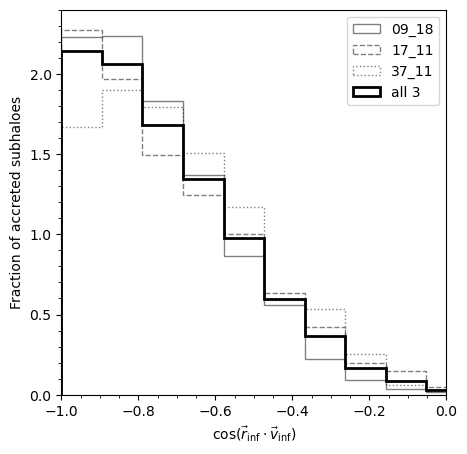

In [27]:
"""
Plot the distribution of satellite infall angles relative to their host galaxy.
cos ≈ -1 → radial infall, cos ≈ 0 → tangential infall.
"""

# Create a square figure for the histogram of infall angle cosine
f, ax = plt.subplots(1, 1, figsize=(5, 5))

# Define the relative position vectors at infall
# r_inf = satellite position at infall (xcinf, ycinf, zcinf)
#        - host (Local Group) center at infall (xclg, yclg, zclg)
rinf = np.zeros((out_2r200.shape[0], 3))
rinf[:, 0] = out_2r200['xcinf'] - out_2r200['xclg']
rinf[:, 1] = out_2r200['ycinf'] - out_2r200['yclg']
rinf[:, 2] = out_2r200['zcinf'] - out_2r200['zclg']

# Define the relative velocity vectors at infall
# v_inf = satellite velocity at infall (vxinf, vyinf, vzinf)
#        - host velocity at infall (vxlg, vylg, vzlg)
vinf = np.zeros((out_2r200.shape[0], 3))
vinf[:, 0] = out_2r200['vxinf'] - out_2r200['vxlg']
vinf[:, 1] = out_2r200['vyinf'] - out_2r200['vylg']
vinf[:, 2] = out_2r200['vzinf'] - out_2r200['vzlg']

# Compute the cosine of the angle between r_inf and v_inf
# This quantifies whether satellites are falling in (cos < 0)
# or moving outward (cos > 0). A value near -1 indicates
# strong infall along the radial direction.
cos = (rinf[:, 0] * vinf[:, 0] +
       rinf[:, 1] * vinf[:, 1] +
       rinf[:, 2] * vinf[:, 2]) / (
    np.sqrt(rinf[:, 0]**2 + rinf[:, 1]**2 + rinf[:, 2]**2) *
    np.sqrt(vinf[:, 0]**2 + vinf[:, 1]**2 + vinf[:, 2]**2)
)

# Plot histograms for each simulation
# Each simulation is plotted with a different line style.
sim_styles = {'09_18':'solid', '17_11':'dashed', '37_11':'dotted'}
for sim, ls in sim_styles.items():
    ax.hist(cos[out_2r200_id == sim],
            bins=np.linspace(-1, 1, 20), density=True,
            color='black', histtype='step', alpha=0.5,
            ls=ls, lw=1, zorder=0, label=sim)
    
# Plot combined distribution (all three simulations)
ax.hist(cos, bins=np.linspace(-1, 1, 20), histtype='step',
        density=True, color='black', lw=2, zorder=1, label='all 3')

# Format axes and labels
ax.set_xlabel(r'$\cos(\vec{r}_\mathrm{inf} \cdot \vec{v}_\mathrm{inf})$')
ax.set_ylabel('Fraction of accreted subhaloes')

# Focus on negative values (infall direction)
ax.set_xlim([-1, 0])
ax.set_ylim([0, 2.4])

# Legend and aspect ratio
ax.legend(loc='upper right')
ax.set_aspect(1 / 2.4)

# Tick marks
ax.set_xticks(np.arange(-1, 0.1, 0.2))
ax.set_yticks(np.arange(0, 2.4, 0.5))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

### How Far Satellites Travel Before Infall

We examine the **distance each satellite travels from its birth location to the host galaxy at infall**.

- Compute the **straight-line distance** between the satellite's **birth position** and its **position at first crossing of the host's virial radius**.  
- Thin lines: distributions from **individual HESTIA simulations** (`09_18`, `17_11`, `37_11`)  
- Thick line: **combined distribution** for all three simulations  

This histogram shows how far satellites move through the Local Group before being accreted by the **Milky Way** or **M31**.

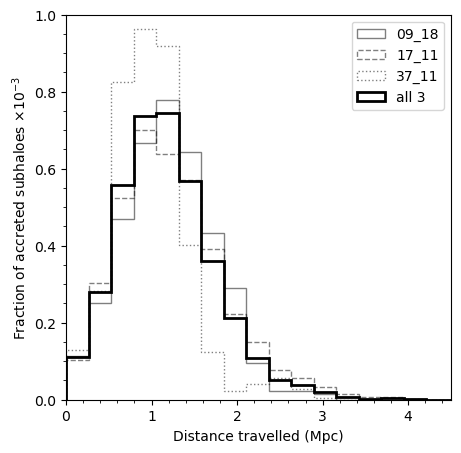

In [31]:
"""
Plot distribution of distances travelled by satellites from birth to infall.
Distance = Euclidean separation between birth position and position at first crossing of host virial radius.
"""

# Position of each subhalo at birth relative to its host (MW/M31 analog)
x0_new = np.array([
    out_2r200['xcbirth'] - out_2r200['xlgbirth'],
    out_2r200['ycbirth'] - out_2r200['ylgbirth'],
    out_2r200['zcbirth'] - out_2r200['zlgbirth']
])

# Position of each subhalo at infall relative to its host
xinf_new = np.array([
    out_2r200['xcinf'] - out_2r200['xclg'],
    out_2r200['ycinf'] - out_2r200['yclg'],
    out_2r200['zcinf'] - out_2r200['zclg']
])

# Euclidean distance between birth and infall positions
# This represents how far each subhalo travelled through space before accretion.
# Units are kpc (converted to Mpc later when plotting).
d_travelled = np.sqrt(
    (xinf_new[0] - x0_new[0])**2 +
    (xinf_new[1] - x0_new[1])**2 +
    (xinf_new[2] - x0_new[2])**2
)

# Plot distribution of distances travelled before accretion
f, ax = plt.subplots(1, 1, figsize=(5, 5))

# Individual simulations (different linestyles)
sim_styles = {'09_18':'solid', '17_11':'dashed', '37_11':'dotted'}
for sim, ls in sim_styles.items():
    ax.hist(d_travelled[out_2r200_id == sim],
            bins=np.linspace(0, 5000, 20), density=True,
            color='black', histtype='step', alpha=0.5,
            ls=ls, lw=1, zorder=0, label=sim)

# Combined distribution
ax.hist(d_travelled, bins=np.linspace(0, 5000, 20),
        histtype='step', density=True, color='black', lw=2, zorder=1, label='all 3')

# Axes formatting
ax.set_xlabel('Distance travelled (Mpc)')
ax.set_ylabel('Fraction of accreted subhaloes $\\times 10^{-3}$')

ax.set_xlim([0, 4500])
ax.set_ylim([0, 0.001])

ax.legend(loc='upper right')
ax.set_aspect(4500 / 0.001)

# Ticks (converted to Mpc units)
ax.set_xticks(np.arange(0, 4500, 1000))
ax.set_yticks(np.arange(0, 0.0011, 0.0002))
ax.set_xticklabels(['0', '1', '2', '3', '4'])
ax.set_yticklabels(['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

### Distance Traveled vs. Infall Redshift

This scatter plot shows how far satellites travel before being accreted (**distance traveled**) as a function of their **infall redshift** ($z_\mathrm{inf}$).

- **Black circles**: dark matter–only halos  
- **Red triangles**: halos containing baryons (gas and/or stars)  

This visualization helps compare the accretion histories of **luminous vs. dark satellites**, and see whether baryonic content affects how far a satellite moves before infall.

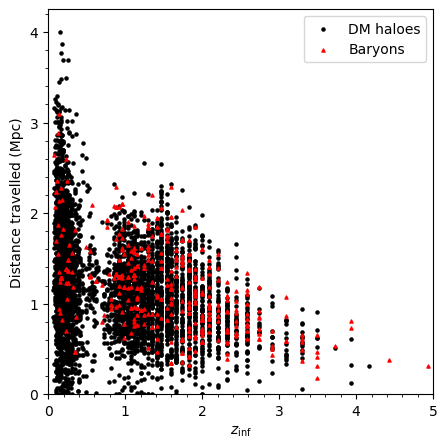

In [ ]:
"""
Scatter plot of distance travelled vs. infall redshift.
- Black circles: DM-only halos
- Red triangles: halos with baryons
Distance is converted from kpc to Mpc.
"""

# Plot the distance travelled by infalling haloes as a function of infall redshift
fig, ax = plt.subplots(figsize=(5, 5))

# Define haloes that contain baryons (gas or stars)
baryons = (out_2r200['Mgas_inf'] != 0) | (out_2r200['Mstar_inf'] != 0)

# Scatter plot: dark-matter-only haloes
ax.scatter(
    out_2r200['zinf'][~baryons],
    d_travelled[~baryons] / 1000,  # convert kpc → Mpc
    marker='o', s=5, color='black', label='DM haloes'
)

# Scatter plot: haloes with baryons
ax.scatter(
    out_2r200['zinf'][baryons],
    d_travelled[baryons] / 1000,
    marker='^', s=5, color='red', label='Baryons'
)

# Axis labels and limits
ax.set_xlabel(r'$z_\mathrm{inf}$')
ax.set_ylabel('Distance travelled (Mpc)')
ax.set_xlim(0, 5)
ax.set_ylim(0, 4.25)

# Legend and aspect ratio
ax.legend(loc='upper right')
ax.set_aspect(5 / 4.25)

# Tick settings
ax.set_xticks(np.arange(0, 5.1, 1))
ax.set_yticks(np.arange(0, 4.1, 1))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

## Preparing Functions for Infall vs. Cosmic-Web Comparisons

We define two helper functions to analyze satellite infall directions relative to the cosmic web:

1. **`uniform_distribution(Nsat)`**  
   - Generates `Nsat` points **uniformly distributed on a sphere** (random isotropic infall).  
   - Repeats 10,000 times to compute the **median and standard deviation** of the |cosine| distribution between random vectors and the radial direction.  
   - Serves as a **reference** for testing whether observed satellite infall directions are isotropic or aligned with cosmic structures.

2. **`cos_eigenvec_rinf_z(infall, rvir, sat='all', smo='5.0', tensor='Tidal')`**  
   - Computes the **absolute cosine of the angle** between satellite infall directions and the **eigenvectors of the local cosmic web** (from tidal or shear tensors).  
   - Supports selection by host (`'mw'`, `'m31'`, or `'all'`) and virial radius (`rvir`).  
   - Returns the |cosine| values relative to the three principal axes, revealing whether satellites preferentially fall along filaments, sheets, or other structures.

These functions will allow us to compare **observed infall directions** to **random isotropic expectations** and to **cosmic-web alignment**.

In [15]:
def uniform_distribution(Nsat):
    """
    Compute the expected cosine distribution for Nsat satellites
    randomly distributed on a sphere.

    Parameters
    ----------
    Nsat : int
        Number of satellites per realization.

    Returns
    -------
    median : ndarray
        Median histogram of |cos(theta)| across realizations.
    std : ndarray
        Standard deviation of the histogram across realizations.
    """
    np.random.seed(0)
    Nsamples = 10_000
    Nbins = 20
    bins = np.linspace(0, 1, Nbins)
    R = 200.0  # kpc

    hist = np.zeros((Nsamples, Nbins - 1))

    for n in range(Nsamples):
        # Generate Nsat points uniformly on a sphere
        u = np.random.uniform(-1, 1, Nsat)             # cos(polar angle)
        theta = np.random.uniform(0, 2 * np.pi, Nsat)  # azimuthal angle
        x = R * np.sqrt(1 - u**2) * np.cos(theta)
        y = R * np.sqrt(1 - u**2) * np.sin(theta)
        z = R * u
        rinf = np.column_stack((x, y, z))

        # Generate a shuffled version to compute random pair alignments
        e = rinf.copy()
        np.random.shuffle(e)

        # Compute |cos(theta)| between matched (rinf, e) vectors
        dot = np.sum(e * rinf, axis=1)
        cos = np.abs(dot / (np.linalg.norm(rinf, axis=1) * np.linalg.norm(e, axis=1)))

        # Compute and store normalized histogram
        hist[n, :], _ = np.histogram(cos, bins=bins, density=True)

    # Median and standard deviation across all realizations
    median = np.median(hist, axis=0)
    std = np.std(hist, axis=0)

    return median, std

In [16]:
def cos_eigenvec_rinf_z(infall, rvir, sat='all', smo='5.0', tensor='Tidal'):
    """
    Compute |cos(theta)| between satellite infall directions and the local eigenvectors
    of the tidal or shear tensor around the Local Group analogs.

    Parameters
    ----------
    infall : DataFrame
        Table containing infall and Local Group coordinates (xcinf, ycinf, zcinf, xclg, yclg, zclg).
    rvir : str
        Virial radius identifier ('1.0rvir' or '2.0rvir').
    sat : {'all', 'mw', 'm31'}, optional
        Subset of satellites to analyze: Milky Way, M31, or all combined.
    smo : str, optional
        Smoothing scale in Mpc/h (default '5.0').
    tensor : {'Tidal', 'Shear'}, optional
        Type of tensor used for eigenvector computation (default 'Tidal').

    Returns
    -------
    cos1, cos2, cos3 : ndarray
        Absolute cosine values between infall directions and the three eigenvectors
        (e1, e2, e3) of the local tensor field.
    """
    # Compute infall direction in Mpc
    rinf = np.column_stack([
        infall['xcinf'] - infall['xclg'],
        infall['ycinf'] - infall['yclg'],
        infall['zcinf'] - infall['zclg']
    ]) / 1000.0  # convert kpc to Mpc if needed

    # Load eigenvectors at satellite positions for each simulation
    eigenv_files = [
        f"eigenvec_output/CIC_8192_GAL_FOR_{sim}_256_{smo}_{tensor}Tensor_Eigenvecs_LGs_{rvir}.npy"
        for sim in SIMS
    ]
    eigenvecs = np.vstack([np.load(f) for f in eigenv_files])

    # Select satellites by type (MW, M31, or all)
    if sat == 'mw':
        condition = (out_r200 if rvir == '1.0rvir' else out_2r200)['sat'] == 2
    elif sat == 'm31':
        condition = (out_r200 if rvir == '1.0rvir' else out_2r200)['sat'] == 1
    else:
        condition = slice(None)  # select all

    # Align eigenvector entries if needed
    if sat == 'all' and rinf.shape[0] != eigenvecs.shape[0]:
        _, _, indices = np.intersect1d(infall['id'], eigenvecs[:, 0], return_indices=True)
        eigenvecs = eigenvecs[indices]

    # Extract the three eigenvector components
    e1 = eigenvecs[condition, 1:4]
    e2 = eigenvecs[condition, 4:7]
    e3 = eigenvecs[condition, 7:10]

    # Compute |cos(theta)| between each eigenvector and infall direction
    rnorm = np.linalg.norm(rinf, axis=1)
    cos1 = np.abs(np.sum(e1 * rinf, axis=1) / rnorm)
    cos2 = np.abs(np.sum(e2 * rinf, axis=1) / rnorm)
    cos3 = np.abs(np.sum(e3 * rinf, axis=1) / rnorm)

    return cos1, cos2, cos3

### Satellite Infall Alignment with the Cosmic Web

We visualize how satellite infall directions align with the **local cosmic web eigenvectors**:

- **Histograms** show $|\cos(\vec{e}_i \cdot \vec{r}_\mathrm{inf})|$ for each of the three eigenvectors $\vec{e}_1$, $\vec{e}_2$, $\vec{e}_3$.
- **Shaded bands** represent the expected distribution for a **random isotropic satellite distribution**, including **1σ (darker) and 2σ (lighter) deviations**.
- **Rows** indicate the measurement radius:
  - Top row: satellites at **R$_{200}$**
  - Bottom row: satellites at **2 × R$_{200}$**
- **Columns** separate satellites by host:
  1. All Local Group satellites
  2. MW satellites only
  3. M31 satellites only
- **Text annotations** above each histogram show the **average deviation from isotropy** in units of σ, providing a quantitative measure of alignment with the cosmic web.

This figure allows us to identify whether satellites preferentially fall along filaments or sheets, and whether this alignment depends on the host galaxy or measurement radius.

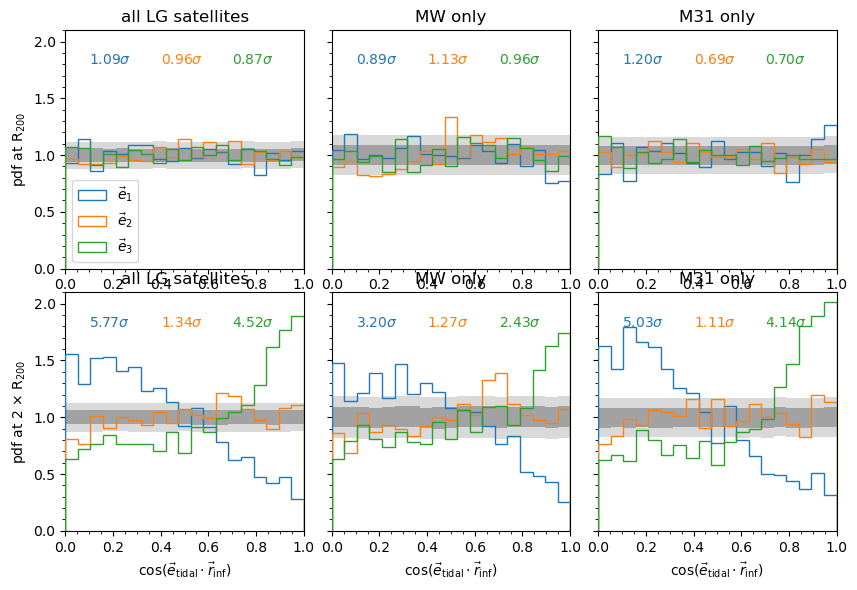

In [17]:
def plot_cosine_distributions(ax, data, rvir, sat_label, smo, tensor, bins, title):
    # Uniform reference
    median, std = uniform_distribution(data.shape[0])
    ax.bar(bins[:-1], 4*std, bottom=median-2*std, width=bins[1]-bins[0],
           align='edge', color='black', alpha=0.15, zorder=1)
    ax.bar(bins[:-1], 2*std, bottom=median-std, width=bins[1]-bins[0],
           align='edge', color='black', alpha=0.25, zorder=2)

    # Compute cosines
    cos1, cos2, cos3 = cos_eigenvec_rinf_z(data, rvir, sat=sat_label, smo=smo, tensor=tensor)

    # Histograms
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    labels = [r'$\vec{e}_1$', r'$\vec{e}_2$', r'$\vec{e}_3$']
    for cos, color, label in zip([cos1, cos2, cos3], colors, labels):
        hist, _, _ = ax.hist(cos, bins=bins, density=True, color=color,
                             histtype='step', label=label, zorder=3)
        significance = np.mean(np.abs(hist - median) / std)
        xpos = 0.1 + 0.3 * labels.index(label)
        ax.text(xpos, 1.8, f'{significance:4.2f}$\\sigma$', color=color)

    # Axis and labels
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 2.1)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.set_aspect(1/2.1)
    ax.set_xticks(np.arange(0, 1.1, 0.2))
    ax.set_yticks(np.arange(0, 2.1, 0.5))
    ax.set_title(title)


# Main plotting code
f, ax = plt.subplots(2, 3, figsize=(10, 6.5))
tensor, smo = 'Tidal', '1.0'
bins = np.linspace(0, 1, 20)

# Row 1: 1×Rvir
plot_cosine_distributions(ax[0,0], out_r200, '1.0rvir', 'all', smo, tensor, bins, 'all LG satellites')
plot_cosine_distributions(ax[0,1], mw_r200, '1.0rvir', 'mw', smo, tensor, bins, 'MW only')
plot_cosine_distributions(ax[0,2], m31_r200, '1.0rvir', 'm31', smo, tensor, bins, 'M31 only')

# Row 2: 2×Rvir
plot_cosine_distributions(ax[1,0], out_2r200, '2.0rvir', 'all', smo, tensor, bins, 'all LG satellites')
plot_cosine_distributions(ax[1,1], mw_2r200, '2.0rvir', 'mw', smo, tensor, bins, 'MW only')
plot_cosine_distributions(ax[1,2], m31_2r200, '2.0rvir', 'm31', smo, tensor, bins, 'M31 only')

# Labels
for j in range(3):
    ax[1,j].set_xlabel(r'$\cos(\vec{e}_{\mathrm{%s}}\cdot\vec{r}_{\mathrm{inf}})$' % tensor.lower())
ax[0,0].set_ylabel(r'pdf at R$_\mathrm{200}$')
ax[1,0].set_ylabel(r'pdf at 2 $\times$ R$_\mathrm{200}$')
ax[0,0].legend(loc='lower left')

# Layout
for j in [1,2]:
    ax[0,j].set_yticklabels([])
    ax[1,j].set_yticklabels([])
f.subplots_adjust(wspace=0.1, hspace=0.1)

### Mass Dependence of Satellite Infall Alignment

We investigate how the alignment of satellite infall directions with the **local tidal tensor eigenvectors** depends on the **infall mass**:

- Satellites are divided into three **mass bins** based on their virial mass at infall, $M_\mathrm{vir}^\mathrm{inf}$:
  1. **Low mass**: $M_\mathrm{vir}^\mathrm{inf} < 10^7\,M_\odot$
  2. **Intermediate mass**: $10^7\,M_\odot \le M_\mathrm{vir}^\mathrm{inf} < 10^8\,M_\odot$
  3. **High mass**: $M_\mathrm{vir}^\mathrm{inf} \ge 10^8\,M_\odot$
  
- For each mass bin, we plot **histograms of $|\cos(\vec{e}_i \cdot \vec{r}_\mathrm{inf})|$** for the three tidal tensor eigenvectors ($\vec{e}_1$, $\vec{e}_2$, $\vec{e}_3$).

- **Shaded bands** indicate the expected distribution for **random isotropic satellite infall**, showing 1σ and 2σ variations.

- **Significance annotations** above each histogram indicate the **average deviation from isotropy in units of σ**, quantifying the alignment strength with the cosmic web.

This allows us to examine whether more massive satellites preferentially infall along filaments or sheets, and whether alignment strength depends on satellite mass.

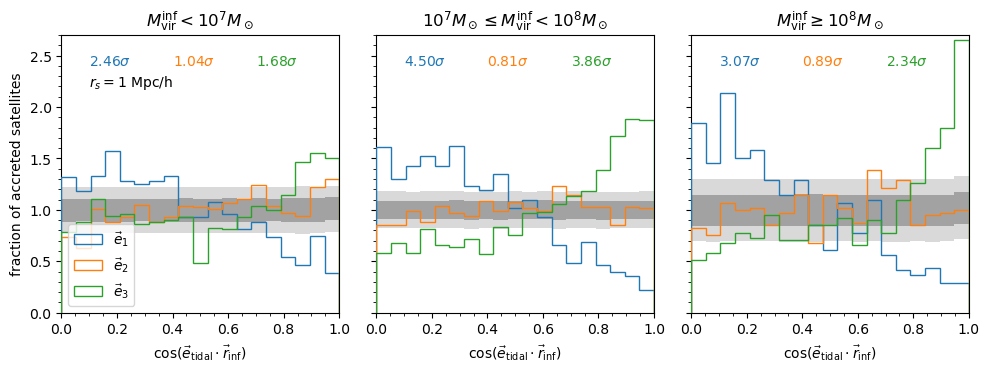

In [18]:
def plot_mass_bin(ax, mask, median, std, cosines, bins, color_labels):
    """Plot one mass bin histogram with uniform reference shading and significance."""
    # Shaded uniform reference
    ax.bar(bins[:-1], 4*std, bottom=median-2*std, width=bins[1]-bins[0],
           align='edge', color='black', alpha=0.15, zorder=1)
    ax.bar(bins[:-1], 2*std, bottom=median-std, width=bins[1]-bins[0],
           align='edge', color='black', alpha=0.25, zorder=2)

    # Plot cosine histograms for each eigenvector
    for i, (cos, color, label) in enumerate(zip(cosines, *color_labels)):
        hist, _, _ = ax.hist(cos[mask], bins=bins, density=True, histtype='step',
                             color=color, label=label, zorder=3+i)
        significance = np.mean(np.abs(hist - median) / std)
        ax.text(0.1 + 0.3*i, 2.4, f'{significance:4.2f}$\\sigma$', color=color)

    # Axes setup
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 2.7)
    ax.set_aspect(1/2.7)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.set_xticks(np.arange(0, 1.1, 0.2))
    ax.set_yticks(np.arange(0, 2.7, 0.5))


# Main plotting code
divider = out_2r200['Mvir_inf']
quantile = np.array([1e7, 1e8])
lower = divider < quantile[0]
middle = (divider >= quantile[0]) & (divider < quantile[1])
higher = divider >= quantile[1]
masks = [lower, middle, higher]
titles = [
    r'$M_\mathrm{vir}^\mathrm{inf} < 10^7 M_\odot$',
    r'$10^7 M_\odot \leq M_\mathrm{vir}^\mathrm{inf} < 10^8 M_\odot$',
    r'$M_\mathrm{vir}^\mathrm{inf} \geq 10^8 M_\odot$'
]

# Figure setup
f, ax = plt.subplots(1, 3, figsize=(10, 5))
Nb, smo, tensor = 20, '1.0', 'Tidal'
bins = np.linspace(0, 1, Nb)

# Uniform references for each mass bin
uniform_refs = [uniform_distribution(out_2r200[m].shape[0]) for m in masks]

# Eigenvector–infall cosines
cos1, cos2, cos3 = cos_eigenvec_rinf_z(out_2r200, rvir='2.0rvir', smo=smo, tensor=tensor)
cosines = [cos1, cos2, cos3]
color_labels = (['tab:blue', 'tab:orange', 'tab:green'],
                [r'$\vec{e}_1$', r'$\vec{e}_2$', r'$\vec{e}_3$'])

# Plot each mass bin
for j, (mask, (median, std)) in enumerate(zip(masks, uniform_refs)):
    plot_mass_bin(ax[j], mask, median, std, cosines, bins, color_labels)
    ax[j].set_title(titles[j])
    ax[j].set_xlabel(r'$\cos(\vec{e}_\mathrm{%s}\cdot\vec{r}_\mathrm{inf})$' % tensor.lower())

# Labels and legend
ax[0].set_ylabel('fraction of accreted satellites')
ax[0].legend(loc='lower left')
ax[0].text(0.1, 2.2, r'$r_s = 1$ Mpc/h')

# Remove redundant y-ticks
for j in [1, 2]:
    ax[j].set_yticklabels([])

f.tight_layout()

### Redshift Dependence of Satellite Infall Alignment

We examine how the alignment of satellite infall directions with the **tidal and shear tensor eigenvectors** depends on the **infall redshift** $z_\mathrm{inf}$:

- Satellites are divided into two populations:
  1. **Early infall**: $z_\mathrm{inf} < 0.7$
  2. **Late infall**: $z_\mathrm{inf} \ge 0.7$

- For each population, we plot **histograms of $|\cos(\vec{e}_i \cdot \vec{r}_\mathrm{inf})|$** for the three eigenvectors of both the **tidal** and **shear tensors**.

- **Shaded bands** indicate the expected distribution for **random isotropic infall**, showing 1σ and 2σ ranges.

- **Significance annotations** quantify the **average deviation from isotropy** in units of σ.

This analysis helps determine whether **early- and late-accreted satellites** preferentially align with cosmic structures differently.

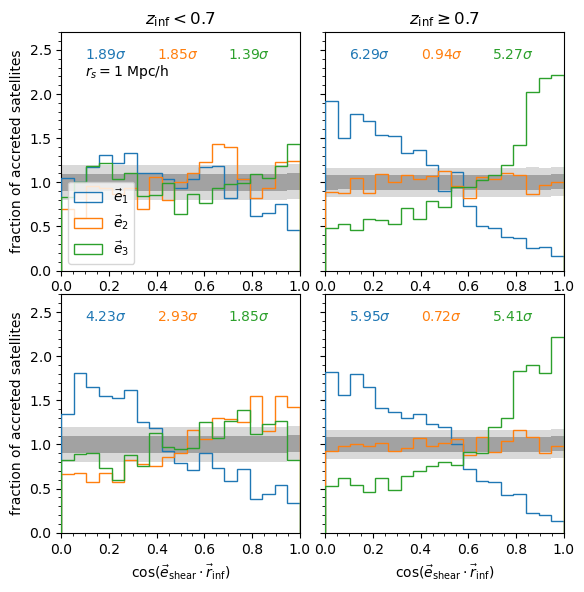

In [19]:
def plot_redshift_bin(ax, mask, median, std, cosines, bins, color_labels):
    """Plot one redshift bin histogram with uniform reference shading and significance."""
    # Shaded uniform reference
    ax.bar(bins[:-1], 4*std, bottom=median-2*std, width=bins[1]-bins[0],
           align='edge', color='black', alpha=0.15, zorder=1)
    ax.bar(bins[:-1], 2*std, bottom=median-std, width=bins[1]-bins[0],
           align='edge', color='black', alpha=0.25, zorder=2)

    # Plot histograms for each eigenvector
    for i, (cos, color, label) in enumerate(zip(cosines, *color_labels)):
        hist, _, _ = ax.hist(cos[mask], bins=bins, density=True, histtype='step',
                             color=color, label=label, zorder=3+i)
        significance = np.mean(np.abs(hist - median) / std)
        ax.text(0.1 + 0.3*i, 2.4, f'{significance:4.2f}$\\sigma$', color=color)

    # Axes setup
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 2.7)
    ax.set_aspect(1/2.7)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.set_xticks(np.arange(0, 1.1, 0.2))
    ax.set_yticks(np.arange(0, 2.7, 0.5))


# Main plotting code
divider = out_2r200['zinf']
quantile = 0.7
lower = divider < quantile
middle = divider >= quantile
masks = [lower, middle]
titles = [r'$z_\mathrm{inf} < 0.7$', r'$z_\mathrm{inf} \geq 0.7$']

# Figure setup
f, ax = plt.subplots(2, 2, figsize=(6.5, 6.5))
Nb, smo = 20, '1.0'
bins = np.linspace(0, 1, Nb)

# Uniform reference for each redshift bin
uniform_refs = [uniform_distribution(out_2r200[m].shape[0]) for m in masks]

# Eigenvector–infall cosines
color_labels = (['tab:blue', 'tab:orange', 'tab:green'],
                [r'$\vec{e}_1$', r'$\vec{e}_2$', r'$\vec{e}_3$'])

for i, tensor in enumerate(['Tidal', 'Shear']):
    cos1, cos2, cos3 = cos_eigenvec_rinf_z(out_2r200, rvir='2.0rvir', smo=smo, tensor=tensor)
    cosines = [cos1, cos2, cos3]

    for j, (mask, (median, std)) in enumerate(zip(masks, uniform_refs)):
        plot_redshift_bin(ax[i, j], mask, median, std, cosines, bins, color_labels)
        ax[i, j].set_xlabel(r'$\cos(\vec{e}_\mathrm{%s}\cdot\vec{r}_\mathrm{inf})$' % tensor.lower())

# Labels and legend
for row in [0, 1]:
    ax[row, 0].set_ylabel('fraction of accreted satellites')
ax[0, 0].legend(loc='lower left')
ax[0, 0].text(0.1, 2.2, r'$r_s = 1$ Mpc/h')

# Set titles
for j, t in enumerate(titles):
    ax[0, j].set_title(t)

# Remove redundant y-tick labels
ax[0, 1].set_yticklabels([])
ax[1, 1].set_yticklabels([])

f.subplots_adjust(wspace=0.1, hspace=0.1)

## Accretion Map in Host Eigenframe (Octant)

This function creates an **Aitoff projection** of satellite infall directions in the **host halo eigenframe**, focusing on the **first octant**:

- Satellites from multiple simulations are combined.
- The frame is aligned with the host halo's **tidal or shear eigenvectors** (`tensor` argument).
- Satellite positions are **rotated to the eigenframe** so that the first three axes correspond to $(\vec{e}_3, \vec{e}_2, \vec{e}_1)$.
- The **Virgo cluster** position is overplotted for reference.
- A **density map** shows the distribution of infall directions within the octant.
- **Grid lines, quarter circles, and axis labels** are added for orientation.

This visualization helps identify **preferred infall directions** relative to the halo's principal axes and compare across simulations.

In [10]:
def accretion_map_octant(gal, gal_id, gal_ids, gal_string, SIMS, smo='5', tensor='Tidal', nx=20, ny=20):
    """Plot the accretion map of galaxies in the first octant using an Aitoff projection."""

    # Helper function: Cartesian -> spherical (radians)
    def cartesian_to_spherical(x, y, z):
        c = SkyCoord(CartesianRepresentation(x, y, z), frame='icrs')
        c.representation_type = 'spherical'
        return c.ra.wrap_at('180d').radian, c.dec.radian

    # Set up Aitoff projection
    f = plt.figure(figsize=(10,10))
    ax = plt.subplot(111, projection="aitoff")
    plt.rcParams.update({'font.size': 6})
    
    sim_markers = ['o','^','s']
    virgo = np.array([
        [4.73332578e+04, 6.01544258e+04, 5.28966133e+04],
        [4.76735000e+04, 6.02137695e+04, 5.12617031e+04],
        [4.79282070e+04, 6.03831094e+04, 5.16541875e+04]
    ])

    # Meshgrid for first octant
    xg = np.linspace(0, np.pi/2, nx)
    yg = np.linspace(0, np.pi/2, ny)
    Xg, Yg = np.meshgrid(xg, yg)
    dens = np.zeros((nx, ny))

    # Flag first octant
    flag = ((Xg >= 0) & (Xg <= np.pi/2) & (Yg >= 0) & (Yg <= np.pi/2)).astype(int)

    # Loop over simulations
    for i, sim in enumerate(SIMS):

        # Galaxy coordinates in host frame
        tab = gal[gal_id == sim]
        X = tab['xcinf'] - tab['xclg']
        Y = tab['ycinf'] - tab['yclg']
        Z = tab['zcinf'] - tab['zclg']

        # Host eigenvectors
        eigenvec = np.load(f'eigenvec_output/CIC_8192_GAL_FOR_{sim}_256_{smo}.0_{tensor}Tensor_Eigenvecs_LG_{gal_ids[i]}.npy')
        m_c = eigenvec[0,1:4]
        e1 = eigenvec[0,4:7]
        e2 = eigenvec[0,7:10]
        e3 = eigenvec[0,10:]

        # Rotation: old -> new axes (e3, e2, e1)
        new_axes = np.array([e3, e2, e1])
        old_axes = np.eye(3)
        rotation_matrix = new_axes @ old_axes.T

        vec = np.array([X, Y, Z]).T
        new_vec = vec @ rotation_matrix.T
        x, y, z = np.abs(new_vec[:,0]), np.abs(new_vec[:,1]), np.abs(new_vec[:,2])

        # Compute spherical coordinates
        ra, dec = cartesian_to_spherical(x, y, z)

        # Histogram
        H, _, _ = np.histogram2d(ra, dec, bins=[nx, ny], range=[[0, np.pi/2],[0, np.pi/2]], density=True)
        dens += H

        # Plot Virgo position
        vec_virgo = virgo[i] - m_c
        vec_virgo_rot = vec_virgo @ rotation_matrix.T
        ra_v, dec_v = cartesian_to_spherical(*np.abs(vec_virgo_rot))
        ax.scatter(ra_v, dec_v, marker=sim_markers[i], s=30, color='white',
                   edgecolors='black', linewidths=0.5, zorder=2, label=sim)

    # Mask outside octant
    dens[flag == 0] = np.nan

    # Plot density
    ax.pcolormesh(Xg, Yg, dens.T, cmap='viridis', vmin=0, vmax=5, zorder=0)

    # Quarter circles & grid
    theta = np.linspace(0.05, np.pi/2-0.02)
    ax.plot(np.pi/12*np.sin(theta), np.pi/12*np.cos(theta), color='lime', lw=1.5, zorder=3)
    theta = np.linspace(-np.pi/2+0.02, -0.05)
    ax.plot(np.pi/2 + np.pi/12*np.sin(theta), np.pi/12*np.cos(theta), color='orange', lw=1.5, zorder=3)
    ax.axhline(np.pi/2 - np.pi/12, xmin=0.505, xmax=0.745, color='cyan', lw=1.5, zorder=3)

    # Dashed grid
    for val in [np.pi/6, np.pi/3]:
        ax.axvline(val, ymin=0.5, ymax=1.5, color='black', lw=0.3, ls='dashed', zorder=1)
        ax.axhline(val, xmin=0.5, xmax=0.75, color='black', lw=0.3, ls='dashed', zorder=1)

    # Solid grid
    ax.axvline(0, ymin=0.5, ymax=1.5, color='black', lw=0.5, zorder=10)
    ax.axvline(np.pi/2, ymin=0.5, ymax=1.5, color='black', lw=0.5, zorder=10)
    ax.axhline(0, xmin=0.5, xmax=0.75, color='black', lw=0.5, zorder=10)

    # Labels
    ax.axis('off')
    ax.text(0, -0.095, '0°')
    ax.text(0.5, -0.093, '30°')
    ax.text(1., -0.09, '60°')
    ax.text(1.5, -0.087, '90°')
    ax.text(-0.12, 0, '0°')
    ax.text(-0.18, 0.5, '30°')
    ax.text(-0.255, 1., '60°')
    ax.text(-1.7, 1.5, '90°')

    ax.text(-0.15, 1.6, '$\\vec{e}_1$', fontsize=10, color='tab:blue')
    ax.text(1.65, -0.1, '$\\vec{e}_2$', fontsize=10, color='tab:orange')
    ax.text(-0.125, -0.125, '$\\vec{e}_3$', fontsize=10, color='tab:green')
    ax.text(2, 1.3, gal_string, fontsize=10)

    ax.plot([], [], ' ', label="virgo", zorder=1)
    ax.legend(loc='upper right', bbox_to_anchor=(0.75, 1))

    return f, ax

### MW Accretion Map (Tidal Tensor, r_s=5 Mpc/h)

(<Figure size 1000x1000 with 1 Axes>, <AitoffAxes: >)

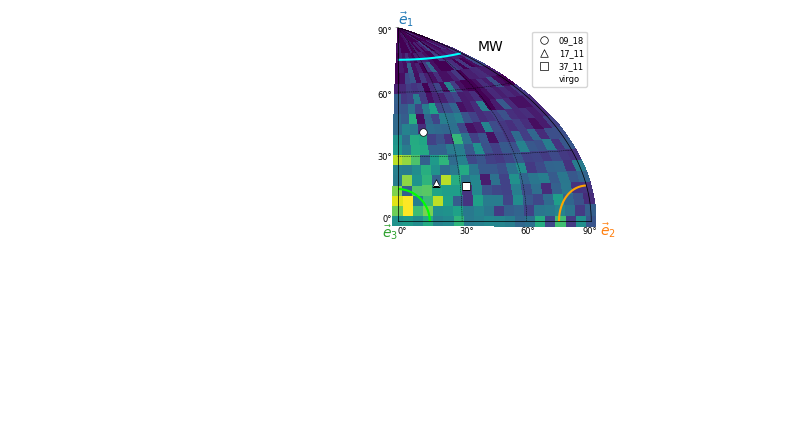

In [11]:
# Plot the Milky Way accretion map in the first octant using Tidal tensor and smoothing scale 5
smo = '5'
tensor = 'Tidal'
mw_ids = ['127000000000003','127000000000003','127000000000002']
accretion_map_octant(mw_2r200, mw_2r200_id, mw_ids, 'MW', SIMS, smo=smo, tensor=tensor)

### Full-Sky Accretion Map in Host Eigenframe

This function computes a **full-sky density map** of satellite infall directions in the **host halo eigenframe**:

- Combines satellites from **multiple simulations**.
- Rotates satellite positions into the **host halo eigenframe**, where the axes correspond to the principal eigenvectors of the tidal or shear tensor (`tensor` argument).
- Accumulates a **density grid** over the full sky for plotting in **Aitoff projection**.
- Returns the **meshgrid (Xg, Yg) and density array** for plotting.

In [7]:
def aitoff_grid(host, host_id, host_ids, virgo, SIMS, smo='5', tensor='Tidal'):
    """Compute 2D density grid in an Aitoff projection for a set of host halos."""

    # Grid resolution
    nx, ny = 40, 20
    xg = np.linspace(-np.pi, np.pi, nx)
    yg = np.linspace(-np.pi/2, np.pi/2, ny)
    Xg, Yg = np.meshgrid(xg, yg)
    dens = np.zeros((nx, ny))

    ras, decs = [], []

    for i, sim in enumerate(SIMS):
        # Select host entries for this simulation
        tab = host[host_id == sim]
        X = tab['xcinf'] - tab['xclg']
        Y = tab['ycinf'] - tab['yclg']
        Z = tab['zcinf'] - tab['zclg']

        # Load eigenvectors of host halo
        eigenvec = np.load(f'eigenvec_output/CIC_8192_GAL_FOR_{sim}_256_{smo}.0_{tensor}Tensor_Eigenvecs_LG_{host_ids[i]}.npy')
        host_c = eigenvec[0, 1:4]
        e1, e2, e3 = eigenvec[0, 4:7], eigenvec[0, 7:10], eigenvec[0, 10:]

        # Build rotation matrix: old axes -> eigenvector frame
        new_axes = np.array([e3, e2, e1])
        old_axes = np.eye(3)
        rotation_matrix = np.inner(new_axes, old_axes)

        # Rotate entry points
        vec = np.array([X, Y, Z]).T
        x, y, z = (vec @ rotation_matrix.T).T

        # Rotate Virgo coordinates
        virgo_vec = np.array(virgo[i]) - host_c
        virgo_rot = virgo_vec @ rotation_matrix.T

        # Ensure positive coordinates in rotated frame
        for j, coord in enumerate(['x', 'y', 'z']):
            if virgo_rot[j] < 0:
                if coord == 'x': x = -x
                if coord == 'y': y = -y
                if coord == 'z': z = -z
                virgo_rot[j] = -virgo_rot[j]

        # Store RA/Dec of rotated Virgo
        c_virgo = SkyCoord(CartesianRepresentation(*virgo_rot), frame='icrs')
        c_virgo.representation_type = 'spherical'
        ras.append(c_virgo.ra.value)
        decs.append(c_virgo.dec.value)

        # Compute RA/Dec of galaxies
        c = SkyCoord(CartesianRepresentation(x, y, z), frame='icrs')
        c.representation_type = 'spherical'
        ra = c.ra.wrap_at('180d').radian
        dec = c.dec.radian

        # Accumulate density histogram
        H, _, _ = np.histogram2d(ra, dec, bins=[nx, ny], 
                                 range=[[-np.pi, np.pi], [-np.pi/2, np.pi/2]], density=True)
        dens += H

    return Xg, Yg, dens

### Full-Sky MW Satellite Accretion in Halo Eigenframe

- Shows the **density of MW satellites** in the **host halo eigenframe** over the full sky.  
- Density is computed from satellites rotated into the MW halo eigenframe using the **tidal tensor eigenvectors** (`tensor='Tidal'`).  
- **Virgo cluster** position is overplotted with **mean ± standard deviation**, showing its location across simulations.  
- **Quarter circles and colored frames** indicate the directions of the principal eigenvectors:
  - $\vec{e}_1$: cyan  
  - $\vec{e}_2$: orange  
  - $\vec{e}_3$: lime  

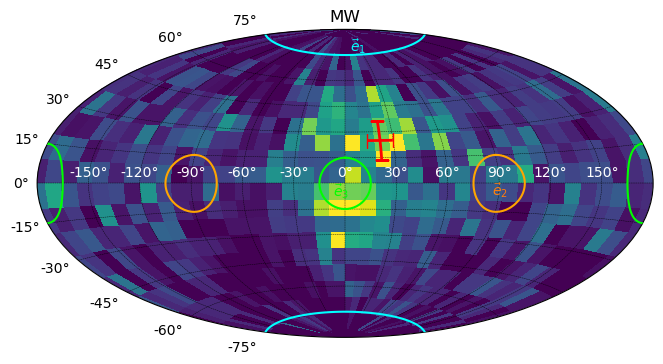

In [14]:
# Plot setup
plt.rcParams.update({'font.size': 10})
f = plt.figure(figsize=(10, 4))
ax = plt.subplot(111, projection='aitoff')
ax.set_title('MW')

# Virgo coordinates for each simulation
virgo = np.array([[4.73332578e+04, 6.01544258e+04, 5.28966133e+04],
                  [4.76735000e+04, 6.02137695e+04, 5.12617031e+04],
                  [4.79282070e+04, 6.03831094e+04, 5.16541875e+04]])

# Compute density grid using aitoff_grid
Xg, Yg, dens_mw = aitoff_grid(mw_2r200, mw_2r200_id, mw_ids, virgo, SIMS, smo='5', tensor='Tidal')

# Plot density
ax.pcolormesh(Xg, Yg, dens_mw.T, cmap='viridis', vmin=0, vmax=1, zorder=0)
ax.grid(True, color='black', lw=0.3, ls='dashed', zorder=3)

# Virgo error bars (mean ± std)
ras = np.array([14.1643583, 18.30805229, 32.85742075, 14.1643583, 18.30805229, 32.85742075])
decs = np.array([41.22780066, 17.46888467, 16.13332611, 41.22780066, 17.46888467, 16.13332611])
ax.errorbar(np.deg2rad(ras.mean()), np.deg2rad(decs.mean()),
            xerr=np.deg2rad(ras.std()), yerr=np.deg2rad(decs.std()),
            marker=None, ecolor='red', elinewidth=2, capsize=5, zorder=2)

# Circles for eigenvector orientation: e1
theta = np.linspace(0, 2*np.pi, 100)
for shift in [0, np.pi, -np.pi]:
    x = shift + np.pi/12 * np.sin(theta)
    y = np.pi/12 * np.cos(theta)
    ax.plot(x, y, color='lime', lw=1.5, zorder=3)

# Circles for eigenvector orientation: e2
x = np.pi/2 + np.pi/12 * np.sin(theta)
y = np.pi/12 * np.cos(theta)
ax.plot(x, y, color='orange', lw=1.5, zorder=3)
x = -np.pi/2 + np.pi/12 * np.sin(theta)
ax.plot(x, y, color='orange', lw=1.5, zorder=3)

# Circles for eigenvector orientation: e3
ax.axhline(np.pi/2 - np.pi/12, color='cyan', lw=1.5, zorder=3)
ax.axhline(-np.pi/2 + np.pi/12, color='cyan', lw=1.5, zorder=3)

# Labels for eigenvectors
ax.text(0.15, 1.35, '$\\vec{e}_1$', fontsize=10, color='cyan')
ax.text(1.5, -0.1, '$\\vec{e}_2$', fontsize=10, color='tab:orange')
ax.text(-0.125, -0.125, '$\\vec{e}_3$', fontsize=10, color='lime')

# Hide tick labels for better visual
for t in ax.xaxis.get_ticklabels():
    t.set_color('white')

f.savefig('accretion.png', dpi=200)